## 1. Incremental constitutive law

### 1.1 Import dependencies

In [1]:
import pickle
import sympy as sym
import numpy as np
from scipy.integrate import solve_ivp
from progressbar import ProgressBar

import matplotlib.pyplot as plt
font = {'size'   : 12}
plt.rc('font', **font)

### 1.2 Sympy symbols and tensors

In [2]:
# Material parameters
K = sym.Symbol('K',real=True) # Bulk modulus
G = sym.Symbol('G',real=True) # Shear modulus
k = sym.Symbol('k',real=True) # Material strength in simple shear
s = sym.Symbol('s',real=True) # transition parameter (s>0, hypoplasticity -- s->\infty, hyperplasticity)

# Components
e11 = sym.Symbol('e_{11}',real=True); e22 = sym.Symbol('e_{22}',real=True); e33 = sym.Symbol('e_{33}',real=True);
e12 = sym.Symbol('e_{12}',real=True); e13 = sym.Symbol('e_{13}',real=True); e21 = sym.Symbol('e_{21}',real=True);
e23 = sym.Symbol('e_{23}',real=True); e31 = sym.Symbol('e_{31}',real=True); e32 = sym.Symbol('e_{32}',real=True) 

de11 = sym.Symbol('\dot{e_{11}}',real=True); de22 = sym.Symbol('\dot{e_{22}}',real=True); de33 = sym.Symbol('\dot{e_{33}}',real=True)
de12 = sym.Symbol('\dot{e_{12}}',real=True); de13 = sym.Symbol('\dot{e_{13}}', real=True); de21 = sym.Symbol('\dot{e_{21}}',real=True)
de23 = sym.Symbol('\dot{e_{23}}',real=True); de31 = sym.Symbol('\dot{e_{31}}',real=True); de32 = sym.Symbol('\dot{e_{32}}',real=True)

z11 = sym.Symbol('z_{11}',real=True); z22 = sym.Symbol('z_{22}',real=True); z33 = sym.Symbol('z_{33}',real=True)
z12 = sym.Symbol('z_{12}',real=True); z13 = sym.Symbol('z_{13}',real=True); z21 = sym.Symbol('z_{21}',real=True)
z23 = sym.Symbol('z_{23}',real=True); z31 = sym.Symbol('z_{31}',real=True); z32 = sym.Symbol('z_{32}',real=True)

dz11 = sym.Symbol('\dot{z}_{11}',real=True); dz22 = sym.Symbol('\dot{z}_{22}',real=True); dz33 = sym.Symbol('\dot{z}_{33}',real=True)
dz12 = sym.Symbol('\dot{z}_{12}',real=True); dz13 = sym.Symbol('\dot{z}_{13}',real=True); dz21 = sym.Symbol('\dot{z}_{21}',real=True)
dz23 = sym.Symbol('\dot{z}_{23}',real=True); dz31 = sym.Symbol('\dot{z}_{31}',real=True); dz32 = sym.Symbol('\dot{z}_{32}',real=True)

sg11 = sym.Symbol('s_{11}',real=True); sg22 = sym.Symbol('s_{22}',real=True); sg33 = sym.Symbol('s_{33}',real=True)
sg12 = sym.Symbol('s_{12}',real=True); sg13 = sym.Symbol('s_{13}',real=True); sg21 = sym.Symbol('s_{21}',real=True)
sg23 = sym.Symbol('s_{23}',real=True); sg31 = sym.Symbol('s_{31}',real=True); sg32 = sym.Symbol('s_{32}',real=True)

# Tensor
E = sym.Array([[e11, e12, e13], [e21, e22, e23], [e31, e32, e33]]) # Total strain
Edot = sym.Array([[de11, de12, de13], [de21, de22, de23], [de31, de32, de33]]) # Total strain incremement
Z = sym.Array([[z11, z12, z13], [z21, z22, z23], [z31, z32, z33]]) # Plastic strain
Zdot = sym.Array([[dz11, dz12, dz13], [dz21, dz22, dz23], [dz31, dz32, dz33]]) # Plastic strain increment
S = sym.Array([[sg11, sg12, sg13], [sg21, sg22, sg23], [sg31, sg32, sg33]]) # Stress

# Arguments of lambdify functions
prms = [K, G, k, s]
args_s = [sg11, sg12, sg13,
          sg21, sg22, sg23,
          sg31, sg32, sg33]
args_de = [de11, de12, de13,
           de21, de22, de23,
           de31, de32, de33]
args = sym.flatten([args_s, prms, args_de])

### 1.3 Build-in functions (sympy)

In [3]:
def to_Array(A):
    return sym.tensorproduct(A)

def sympy_compute_spherical_deviatoric(A):
    ''' Take a nxn matrix and return its spherical and deviatoric parts'''
    if A.shape[0] != A.shape[1]: print("matrix has to be square"); return
    dim = A.shape[0]
    a_hyd = sym.tensorcontraction(A,(0,1))
    A_hyd = a_hyd * to_Array(sym.eye(dim,dim))/3
    A_dev = A - A_hyd
    return A_hyd, A_dev

### 1.4 Compute spherical and deviatoric parts

In [4]:
E_hyd, E_dev = sympy_compute_spherical_deviatoric(E)  # [ε] spheric and [ε] deviatoric
Edot_hyd, Edot_dev = sympy_compute_spherical_deviatoric(Edot)  # [Δε] spheric and [Δε] deviatoric
Z_hyd,Z_dev = sympy_compute_spherical_deviatoric(Z) # [Z] spheric and [Z] deviatoric
Zdot_hyd,Zdot_dev = sympy_compute_spherical_deviatoric(Zdot) # [ΔZ] spheric and [ΔZ] deviatoric
S_hyd, S_dev = sympy_compute_spherical_deviatoric(S) # [Σ] spheric and [Σ] deviatoric

### 1.5 Compute stress and plastic strain increments

In [5]:
A = sym.tensorcontraction(sym.tensorcontraction(sym.tensorproduct(S_dev,Edot_dev),(0,2)),(0,1))
B = sym.tensorcontraction(sym.tensorcontraction(sym.tensorproduct(S_dev,S_dev),(0,2)),(0,1))

Zdot_tensor = (sym.Abs(A)/(2*sym.Pow(k,2)))*(sym.Pow(sym.sqrt(B)/(sym.sqrt(2)*k),(s-2)))*S_dev
Sdot_tensor = 2*G*(Edot_dev-Zdot_tensor)
Sdot_tensor = Sdot_tensor + 3*K*Edot_hyd

func_Zdot_tensor = sym.lambdify(args, Zdot_tensor)
func_Sdot_tensor = sym.lambdify(args, Sdot_tensor)

### 1.6 Build-in functions (numpy)

In [6]:
def Voigt_to_Tensor(vector, strain=False):
    ''' Return tensor from Voigt representation '''
    
    mult=1.
    if strain==True: mult=.5
    tensor=np.asarray([vector[0],       mult*vector[5], mult*vector[4],
                       mult*vector[5],  vector[1],      mult*vector[3],
                       mult*vector[4],  mult*vector[3], vector[2]],
                       dtype=np.float64)
    tensor=tensor.reshape((-1,3))
    return tensor

def Tensor_to_Voigt(tensor, strain=False):
    ''' Return Voigt representation of a tensor '''
    
    mult=1.
    if strain==True: mult=2.
    voigt=np.array([tensor[0,0],      tensor[1,1],      tensor[2,2],
                    mult*tensor[1,2], mult*tensor[0,2], mult*tensor[0,1]])
    return voigt
    
def calculate_energy(gamma_el,K,G):
    ''' Compute Helmholtz free energy '''
    
    gamma_el = Voigt_to_Tensor(gamma_el,
                               strain=True)
    gamma_el_v = find_spherical_part(gamma_el,
                                     strain=True)
    gamma_el_d = find_dev(gamma_el,
                          strain=True)
    F = 0.5*K*gamma_el_v**2 + 0.5*G*gamma_el_d**2
    return F  

def dissipation(stress,d_eps_pl):
    ''' Compute dissipation rate '''
    
    stress=Voigt_to_Tensor(stress)
    d_eps_pl=Voigt_to_Tensor(d_eps_pl,
                             strain=True)
    tau2=find_dev(stress)
    eq_dot2=find_dev(d_eps_pl,
                     strain=True)
    D=tau2*eq_dot2
    return D

def find_spherical_part(tensor,strain=False):
    ''' Compute spherical part of a tensor '''
    
    mult=1./3.
    if strain==True: mult=1.
    return np.trace(tensor)*mult

def find_deviatoric_tensor(tensor):
    ''' Compute deviatoric tensor '''

    return tensor-np.trace(tensor)*np.eye(3)/3.

def find_dev(tensor,strain=False):
    ''' Compute deviatoric part of a tensor '''
    
    mult=2.
    if strain==False: mult=.5
    dev_tensor=find_deviatoric_tensor(tensor)
    dev=np.sum(np.multiply(dev_tensor,dev_tensor))         
    return np.sqrt(mult*dev)

### 1.7 Incremental constitutive relations

In [7]:
def incremental_constitutive(t,y,de,params):
    K, G, k, s = params
    y_tensor = Voigt_to_Tensor(y)
    de_tensor = Voigt_to_Tensor(de,strain=True)
    sol_S = np.array(func_Sdot_tensor(y_tensor[0,0], y_tensor[0,1], y_tensor[0,2],
                                      y_tensor[1,0], y_tensor[1,1], y_tensor[1,2],
                                      y_tensor[2,0], y_tensor[2,1], y_tensor[2,2],
                                      params[0], params[1],
                                      params[2], params[3],
                                      de_tensor[0,0], de_tensor[0,1], de_tensor[0,2],
                                      de_tensor[1,0], de_tensor[1,1], de_tensor[1,2],
                                      de_tensor[2,0], de_tensor[2,1], de_tensor[2,2]))
    sol_Z = np.array(func_Zdot_tensor(y_tensor[0,0], y_tensor[0,1], y_tensor[0,2],
                                      y_tensor[1,0], y_tensor[1,1], y_tensor[1,2],
                                      y_tensor[2,0], y_tensor[2,1], y_tensor[2,2],
                                      params[0], params[1],
                                      params[2], params[3],
                                      de_tensor[0,0], de_tensor[0,1], de_tensor[0,2],
                                      de_tensor[1,0], de_tensor[1,1], de_tensor[1,2],
                                      de_tensor[2,0], de_tensor[2,1], de_tensor[2,2]))
    voigt_Sdot = Tensor_to_Voigt(sol_S)
    voigt_Zdot = Tensor_to_Voigt(sol_Z,strain=True)
    return np.array([voigt_Sdot,voigt_Zdot]).flatten()

def perform_constitutive_increment(strain_increment, state, params):
    y0, t0 = state, 0.0
    tol_e = 1.e+3; tol_s = 1.e-3; gl_tol = 1.e-8
    statetdt = solve_ivp(fun=lambda t, y: incremental_constitutive(t,y,strain_increment,params),
                         t_span=[0.,1.],
                         y0 = y0,
                         method='RK23', rtol = 1.e-6,
                         atol = gl_tol * np.array([tol_s,tol_s,tol_s,
                                                   tol_s,tol_s,tol_s,
                                                   tol_e,tol_e,tol_e,
                                                   tol_e,tol_e,tol_e]))
    status = statetdt.success
    if status==False : print("solve_ivp didn't converge")
    return statetdt.y[:,-1:].flatten()

### 1.8 Refine and structure data 

In [8]:
def refine_structure_data(svars_tdt,params,increments):
    '''Refine the data and split in couple of states at time t and time t+dt'''
    
    K_param, G_param, k_param, s_param = params
    svars_t=np.array([svars_tdt[i-1] for i in range(0,increments)]); svars_t[0]=0.*svars_t[0]
    svars_t[np.arange(0,len(svars_t),n_reset)]=np.zeros(len(svars_tdt[0])) # svars at time t
    
    stress_t=svars_t[:,:6]
    pl_strain_t=svars_t[:,6:12]
    strain_t=svars_t[:,12:18]
    
    stress_tdt=svars_tdt[:,:6]
    pl_strain_tdt=svars_tdt[:,6:12]
    strain_tdt=svars_tdt[:,12:18]
    
    delta_pl_strain = pl_strain_tdt-pl_strain_t
    el_strain_t = strain_t-pl_strain_t
    el_strain_tdt = strain_tdt-pl_strain_tdt
    
    dissipation_rate_tdt = np.array([dissipation(stress_tdt[i],delta_pl_strain[i])
                                     for i in range(0,increments)])
    energy_tdt = np.array([calculate_energy(el_strain_tdt[i],K_param,G_param)
                           for i in range(0,increments)])
    return stress_t,stress_tdt,pl_strain_t,pl_strain_tdt,el_strain_t,el_strain_tdt,strain_t,strain_tdt,energy_tdt,dissipation_rate_tdt

## 2. Data generation

### 2.1 Material parameters

In [9]:
E_param = 200.e+3 # Young modulus
v_param = 0.3 # Poisson's coefficient
K_param = E_param/(3*(1-2*v_param)) # Bulk modulus
G_param = E_param/(2*(1+v_param)) # Shear modulus
S_y = 200. # Strength in simple shearing
s = 1.5 # transition hypo-hyper parameter

params = [K_param, G_param, S_y/np.sqrt(2),s]

### 2.2 Increments and prescribed strain path

In [10]:
increments = 400 # number of increments
n_reset = 200 # number of increments before resetting

mod = 1e-4 # amplitude
deps_inc = np.zeros((increments,6))
for i in range(n_reset):
    deps_inc[i,5] = mod * np.sign(np.cos((2*i*np.pi)/(0.5*n_reset))) # first path
    deps_inc[n_reset+i,5] = 2*mod * np.sign(np.cos((2*i*np.pi)/(0.5*n_reset))) # second path

### 2.3 Generate data from prescribed strain path

In [11]:
epsilon_tdt=np.zeros((increments,6))
svars_tdt=np.zeros((increments,18)) # stress (6), plastic strain (6:12), total strain (12:18)  

tol=1e-24; # do not modify

pbar = ProgressBar()
for i in pbar(range(increments)):
    if not i % n_reset:
        svarsGP_t=np.zeros(18)+tol
          
    epsilon_tdt[i]=svarsGP_t[12:18]+deps_inc[i]
    svars_tdt[i,:12] = perform_constitutive_increment(deps_inc[i],svarsGP_t[:12],params)
    svars_tdt[i,12:18]=epsilon_tdt[i]
    svarsGP_t=svars_tdt[i]

print("Incrementation completed\nProcessing data")

Incrementation completed
Processing data


### 2.4 Restructure data

In [12]:
data = refine_structure_data(svars_tdt,params,increments)
stress_t,stress_tdt,pl_strain_t,pl_strain_tdt,el_strain_t,el_strain_tdt,strain_t,strain_tdt,energy_tdt,dissipation_rate_tdt = data

In [13]:
volumetric_el_strain_tdt = np.array([find_spherical_part(Voigt_to_Tensor(el_strain_tdt[i],strain=True),strain=True)
                                     for i in range(0,increments)])

deviatoric_el_strain_tdt = np.array([find_dev(Voigt_to_Tensor(el_strain_tdt[i],strain=True),strain=True)
                                     for i in range(0,increments)])

deviatoric_delta_pl_strain = np.array([find_dev(Voigt_to_Tensor(pl_strain_tdt[i]-pl_strain_t[i],strain=True),strain=True)
                                       for i in range(0,increments)])

### 2.5 Plot data

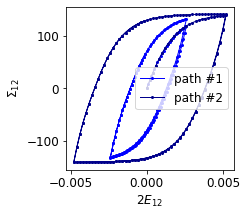

In [14]:
plt.rcParams["figure.figsize"] = (3,3)
fig, ax = plt.subplots(1)

ax.plot(strain_t[:n_reset,5], stress_t[:n_reset,5],
        marker='o',markersize=2, linewidth=1, color='blue',label='path #1')
ax.plot(strain_t[n_reset:,5], stress_t[n_reset:,5],
        marker='o',markersize=2, linewidth=1, color='darkblue',label='path #2')
ax.set_xlabel('$2E_{12}$')
ax.set_ylabel('$\Sigma_{12}$')
ax.legend()

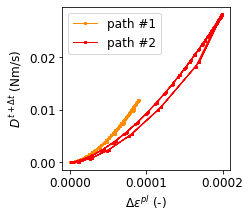

In [15]:
fig, ax = plt.subplots(1)
plt.plot(deviatoric_delta_pl_strain[:n_reset],
         dissipation_rate_tdt[:n_reset],
         marker='s',markersize=2, linewidth=1, color='darkorange',label='path #1')
plt.plot(deviatoric_delta_pl_strain[n_reset:],
         dissipation_rate_tdt[n_reset:],
         marker='s',markersize=2, linewidth=1, color='red',label='path #2')
ax.set_xlabel('$\Delta \epsilon^{pl}$ (-)')
ax.set_ylabel('$D^{t+\Delta t}$ (Nm/s)')
ax.legend()

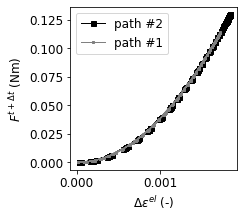

In [16]:
fig, ax = plt.subplots(1)
plt.plot(deviatoric_el_strain_tdt[n_reset:],
         energy_tdt[n_reset:],
         marker='s',markersize=5, linewidth=1, color='black',label='path #2')
plt.plot(deviatoric_el_strain_tdt[:n_reset],
         energy_tdt[:n_reset],
         marker='s',markersize=2, linewidth=1, color='gray',label='path #1')
ax.set_xlabel('$\Delta \epsilon^{el}$ (-)')
ax.set_ylabel('$F^{t+\Delta t}$ (Nm)')
ax.legend()